# Final A: Differential Drive Robot Motion Planning

For your final, you will be developing a motion planner for a *differential drive* mobile robot.  A differential drive robot has two wheels that can be driven independently of one another.  If both are spun forward simultaneously, the robot drives forward.  If one is spun forward and the other backward at the same speed, then the robot spins in place.

The state space is the standard $q=(x,y,\theta)$ state space in SE(3), and the controls are the two wheel speeds $u = (v_{l},v_{r})$.  The rate at which the robot changes its angle depends on the *wheel base* $b$, which is the distance between the two wheels.  The dynamics are defined as follows:

\begin{equation}
\dot{q} = f(q,u) = \begin{bmatrix} \frac{1}{2} (v_l+v_r) \cos(\theta) \\  \frac{1}{2} (v_l+v_r) \sin(\theta) \\ (v_r - v_l) / b \end{bmatrix}
\end{equation}

This means that for given control, the rate of change in the robot's forward direction is the average of the two wheel velocities, and the rate of change in angle is proportional to the difference between the wheel velocities.  The vehicle cannot move instantaneously sideways.

In [1]:
%load_ext autoreload
%autoreload 2

#these might be useful
from klampt import *
from IPython.display import clear_output
import ipywidgets as widgets
import ipyklampt
import numpy as np
import math

In [2]:
from klampt.math import vectorops

class DifferentialDrive:
    """Model of a differential drive robot with state space (x,y,theta).
    
    At the 0 configuration, the robot points in the x direction.
    Theta is measured CCW from x.
    """
    state_names = ['x','y','theta']
    control_names = ['vleft','vright']
    
    def __init__(self,wheelBase,maxWheelSpeed=1):
        if wheelBase <= 0:
            raise ValueError("Wheel base needs to be positive")
        self.wheelBase = wheelBase
        self.ulim = [-maxWheelSpeed,maxWheelSpeed]
    
    def derivative(self,q,u):
        theta = q[2]
        vleft,vright = u
        vfwd = (vleft + vright)*0.5
        #-dtheta*self.wheelBase*0.5 = vleft - vfwd
        #dtheta*self.wheelBase*0.5 = vright - vfwd
        dtheta = (vright - vleft)/self.wheelBase
        c,s = math.cos(theta),math.sin(theta)
        return [vfwd*c,vfwd*s,dtheta]
    
    def integrate(self,q0,t0,u,dt,T):
        """Uses Euler integration to produce a state trajectory.
        - q0: the start state
        - t0: the start time (usually 0)
        - u: the control.  Either a constant 2-vector or a function u(q,t) producing the control
             policy.
        - dt: the step size
        - T: the total duration
        
        Return value: a list of states q0,...,qN.  These are evenly spaced in time, 
        but If T is not divisible by dt, then the last state is evaluated at T, not N*dt.
        """
        res = [q0]
        q = q0
        t = t0
        while t < T:
            if callable(u):
                U = u(q,t)
                dq = self.derivative(q,U)
            else:
                dq = self.derivative(q,u)
            q = vectorops.madd(q,dq,min(dt,T-t))
            res.append(q)
            t += dt
        return res
    
    def plot(self,q,ax,**kwargs):
        theta = q[2]
        c,s = math.cos(theta),math.sin(theta)
        wheelrad = self.wheelBase/3.0
        lw = [q[0]-s*self.wheelBase*0.5,q[1]+c*self.wheelBase*0.5]
        rw = [q[0]+s*self.wheelBase*0.5,q[1]-c*self.wheelBase*0.5]
        ax.plot([lw[0]+wheelrad*c,lw[0]-wheelrad*c],[lw[1]+wheelrad*s,lw[1]-wheelrad*s],lw=5,**kwargs)
        ax.plot([rw[0]+wheelrad*c,rw[0]-wheelrad*c],[rw[1]+wheelrad*s,rw[1]-wheelrad*s],lw=5,**kwargs)
        ax.plot([lw[0]+wheelrad*c*0.1,rw[0]+wheelrad*c*0.1],[lw[1]+wheelrad*s*0.1,rw[1]+wheelrad*s*0.1],lw=5,**kwargs)
        ax.plot([lw[0]-wheelrad*c*0.1,rw[0]-wheelrad*c*0.1],[lw[1]-wheelrad*s*0.1,rw[1]-wheelrad*s*0.1],lw=5,**kwargs)

dd = DifferentialDrive(0.3)  #30cm wheel base
q0 = (0,0,0)
print dd.derivative(q0,[1,1])   #move forward   #the speed vector of move forward
print dd.derivative(q0,[-1,-1])   #move backward   #the speed vector of move backward
print dd.derivative(q0,[1,0])   #move left wheel forward   #the speed vector of move left wheel
print dd.derivative(q0,[0,-1])   #move right wheel backward   #the speed vector of move right wheel backward
print dd.derivative(q0,[-1,1])  #turn in place   #the speed vector of turn in place in CCW direction

[1.0, 0.0, 0.0]
[-1.0, -0.0, 0.0]
[0.5, 0.0, -3.3333333333333335]
[-0.5, -0.0, -3.3333333333333335]
[0.0, 0.0, 6.666666666666667]


## Integration

This is a dynamical system, which can be integrated forward through Euler integration.  The integrate function accepts either a constant, open loop, or closed loop control.

<IPython.core.display.Javascript object>


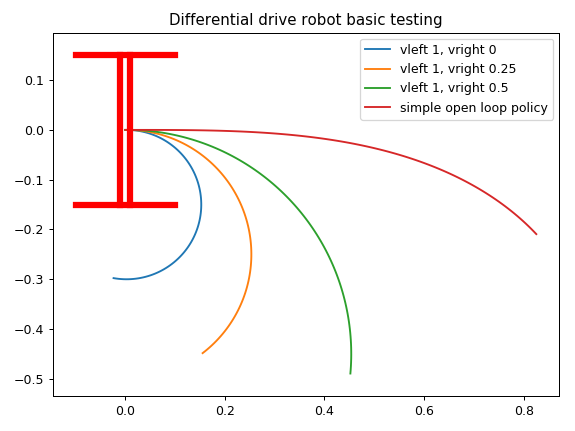

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
xtraj = np.array(dd.integrate(q0,0,[1,0],1e-2,1)) #start from (0,0,0) and time 0, with vl=1, vr=0, time step 1e-2, total time 1
ax.plot(xtraj[:,0],xtraj[:,1],label='vleft 1, vright 0') 

xtraj = np.array(dd.integrate(q0,0,[1,0.25],1e-2,1))
ax.plot(xtraj[:,0],xtraj[:,1],label='vleft 1, vright 0.25') #vl=1, vr=0.25

xtraj = np.array(dd.integrate(q0,0,[1,0.5],1e-2,1))
ax.plot(xtraj[:,0],xtraj[:,1],label='vleft 1, vright 0.5') #vl=1, vr=0.5


xtraj = np.array(dd.integrate(q0,0,lambda x,t:[1,1-t*0.5],1e-2,1)) 
ax.plot(xtraj[:,0],xtraj[:,1],label='simple open loop policy') #vl, vr using open loop policy, vl=1, vr=1-0.5*t

dd.plot(q0,ax,color='r')

plt.legend()
plt.title("Differential drive robot basic testing")
plt.axis('equal')
plt.tight_layout()
plt.show()

## Closed loop line tracking

In this example, the closed-loop policy tries to move along a line by setting up an error term that measures the distance between the robot and the line.  A PID control is then used to steer the robot, with forward velocity maximized (within the speed limits of the wheels).

<IPython.core.display.Javascript object>


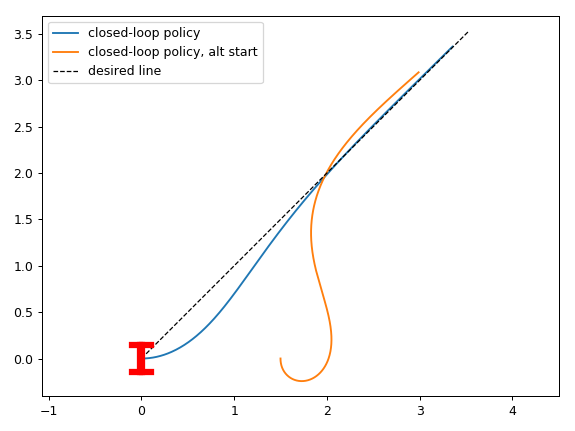

In [4]:
source = (0,0)
direction = vectorops.unit([1,1])
def closed_loop_policy(q,t):
    center = q[0],q[1]
    theta = q[2]
    #compute distance to line
    perp = (-direction[1],direction[0]) #perpendi cular direction, rotate 90 degree CCW
    progress = vectorops.dot(vectorops.sub(center,source),direction) #travelling distance in the forward direction
    dperp = vectorops.dot(vectorops.sub(center,source),perp) #travelling distance in the perpendicular direction
    #dperp is the signed perpendicular distance to the line
    #use this as an error signal
    E = dperp
    vdesired = 1.0
    c,s = math.cos(theta),math.sin(theta)
    #this is the derivative of the error signal
    dE = vectorops.dot(perp,[c*vdesired,s*vdesired])
    kP = 2
    kD = 0.3
    turnRate = -kP*E-kP*dE #just PD control here, PID as control
    u = [vdesired-turnRate*dd.wheelBase*0.5,vdesired+turnRate*dd.wheelBase*0.5] #vl and vr
    scale = 1
    if abs(u[0]) > dd.ulim[1]:
        scale =  dd.ulim[1] / abs(u[0])
    if abs(u[1])*scale > dd.ulim[1]:
        scale =  dd.ulim[1] / abs(u[1])
    return u[0]*scale,u[1]*scale

fig = plt.figure()
ax = plt.subplot(111)
xtraj = np.array(dd.integrate(q0,0,closed_loop_policy,1e-2,5))
ax.plot(xtraj[:,0],xtraj[:,1],label='closed-loop policy')
xtraj = np.array(dd.integrate((1.5,0,-math.pi/2),0,closed_loop_policy,1e-2,5))
ax.plot(xtraj[:,0],xtraj[:,1],label='closed-loop policy, alt start')
ax.plot([source[0],source[0]+5*direction[0]],[source[1],source[1]+5*direction[1]],lw=1,color='k',linestyle='--',label='desired line')

dd.plot(q0,ax,color='r')

plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

## Assignment

Your assignment is to plan approximate paths between start and goal states for the differential drive robot.  We have provided for you a Dijkstra's algorithm that will be able to search between any two states on a 3D grid.  However, the edges and costs of the graph are not defined properly.

Each node N of the graph is a grid index (i,j,k), and each edge is a pair (i,j,k) -> (i',j',k').  We convert from states to nodes and vice versa using the terminology q(N) (node_to_state function) and N(q) (state_to_node function). Each edge is also associated with a cost and an *action*, which is defined as a control and a duration.  You should define the edges so they correspond fairly well with the dynamics of the system.  In other words, you are allowed to add an edge N -> N' when given start state q(N) and an action (u,dt), simulation of that action leads to the end state q(N').  You should ensure that the cost is equivalent to the duration of the action dt, and that the controls $u$ always obey the bounds $|v_l| \leq 1$ and $|v_r| \leq 1$.

With a constant control, you cannot make sure in general that an edge ends at q(N') exactly. So as a first pass, there will be some "slop" that you will not eliminate. 

The performance of search is greatly determined by the grid resolution.  There is also the choice of which actions you allow from a given state, which determines how many edges emanate from each node. For tractability, you would like to pick as few actions as possible while still covering a sufficient diversity of options.

In [5]:
#make some bounds
qmin = [-4,-4,-math.pi]
qmax = [4,4,math.pi]
dims = [20,20,20]

#define the search sraph 
def node_to_state(N):
    """Returns the state for node N=(i,j,k)"""
    return tuple([qmin[i] + float(N[i])/dims[i]*(qmax[i]-qmin[i]) for i in range(3)]) #given a node index, get the state

def state_to_node(q):
    """Returns the closest node to state q"""
    return tuple([int((q[i]-qmin[i])*dims[i]/(qmax[i]-qmin[i])) for i in range(3)]) #given a state, get the node index

'''def cost_action(N, neighbor, wheelBase, ulim, dt):
    state_N = node_to_state(N)
    state_neighbor = node_to_state(neighbor)
    x_N = state_N[0]
    y_N = state_N[1]
    theta_N = state_N[2]
    x_neighbor = state_neighbor[0]
    y_neighbor = state_neighbor[1]
    theta_neighbor = state_neighbor[2]
    distance = math.sqrt((x_neighbor - x_N)**2 + (y_neighbor - y_N)**2)
    
    # case 1 Unreachable sideaway neighbour point
    if vectorops.dot([x_neighbor - x_N, y_neighbor - y_N], [math.cos(theta_N), math.sin(theta_N)]) == 0 and distance < wheelBase/2.0:
        cost = distance/ulim + wheelBase*math.pi/(2*ulim)
        v_l = 0
        v_r = 0
        print "unreachable"
    # case 2 rotation in place
    elif x_neighbor == x_N and y_neighbor == y_N:
        v_l = -ulim
        v_r = ulim
        cost = abs(wheelBase * (theta_neighbor - theta_N)/(2*ulim))
        print "rotate in place"
    # case 3 move straight forward or backward
    elif theta_neighbor == theta_N:
        if (N[0] < neighbor[0] or N[1] < neighbor[1]):
            v_l = ulim
            v_r = ulim
        else:
            v_l = -ulim
            v_r = -ulim
        cost = distance/ulim
        print "straight"
    # case 4 general case
    else:
        R = distance/(2*abs(math.sin((theta_neighbor - theta_N)/2)))
        v_r = ulim
        v_l = ulim*(R - wheelBase/2.0)/(R + wheelBase/2.0)
        cost = abs(2 * R * (theta_neighbor - theta_N)/(v_l + v_r))
        print "general"
    action = ([v_l, v_r], dt)
    return (cost, action)'''

def cost_action(N, neighbor, wheelBase, ulim):
    # get states
    state_N = node_to_state(N)
    state_neighbor = node_to_state(neighbor)
    x_N = state_N[0]
    y_N = state_N[1]
    theta_N = state_N[2]
    x_neighbor = state_neighbor[0]
    y_neighbor = state_neighbor[1]
    theta_neighbor = state_neighbor[2]
    distance = math.sqrt((x_neighbor - x_N)**2 + (y_neighbor - y_N)**2)
    
    # case 1: right
    if neighbor[0] == N[0] + 1 and neighbor[1] == N[1] and neighbor[2] == N[2]:
        c1 = abs((theta_N * wheelBase)/(2 * ulim))
        c2 = distance/ulim
        c3 = c1
        u1 = ([ulim, -ulim], c1)
        u2 = ([ulim, ulim], c2)
        u3 = ([-ulim, ulim], c3)
        cost = c1+c2+c3
        control = ([(u1[0][0]*c1+u2[0][0]*c2+u3[0][0]*c3)/(c1+c2+c3), (u1[0][1]*c1+u2[0][1]*c2+u3[0][1]*c3)/(c1+c2+c3)], c1+c2+c3)
    # case 2: forward
    elif neighbor[1] == N[1] + 1 and neighbor[0] == N[0] and neighbor[2] == N[2]:
        c1 = abs(((math.pi/2 - theta_N) * wheelBase)/(2 * ulim))
        c2 = distance/ulim
        c3 = c1
        u1 = ([-ulim, ulim], c1)
        u2 = ([ulim, ulim], c2)
        u3 = ([ulim, -ulim], c3)
        cost = c1+c2+c3
        control = ([(u1[0][0]*c1+u2[0][0]*c2+u3[0][0]*c3)/(c1+c2+c3), (u1[0][1]*c1+u2[0][1]*c2+u3[0][1]*c3)/(c1+c2+c3)], c1+c2+c3)
    # case 3: up
    elif neighbor[2] == N[2] + 1 and neighbor[0] == N[0] and neighbor[1] == N[1]:
        c = abs((theta_neighbor - theta_N)*wheelBase/(2 * ulim))
        u = ([-ulim, ulim], c)
        cost = c
        control = u
    # case 4: left
    elif neighbor[0] == N[0] - 1 and neighbor[1] == N[1] and neighbor[2] == N[2]:
        c1 = abs((theta_N * wheelBase)/(2 * ulim))
        c2 = distance/ulim
        c3 = c1
        u1 = ([ulim, -ulim], c1)
        u2 = ([-ulim, -ulim], c2)
        u3 = ([-ulim, ulim], c3)
        cost = c1+c2+c3
        control = ([(u1[0][0]*c1+u2[0][0]*c2+u3[0][0]*c3)/(c1+c2+c3), (u1[0][1]*c1+u2[0][1]*c2+u3[0][1]*c3)/(c1+c2+c3)], c1+c2+c3)
    # case 5: backward
    elif neighbor[1] == N[1] - 1 and neighbor[0] == N[0] and neighbor[2] == N[2]:
        c1 = abs(((math.pi/2 - theta_N) * wheelBase)/(2 * ulim))
        c2 = distance/ulim
        c3 = c1
        u1 = ([-ulim, ulim], c1)
        u2 = ([-ulim, -ulim], c2)
        u3 = ([ulim, -ulim], c3)
        cost = c1+c2+c3
        control = ([(u1[0][0]*c1+u2[0][0]*c2+u3[0][0]*c3)/(c1+c2+c3), (u1[0][1]*c1+u2[0][1]*c2+u3[0][1]*c3)/(c1+c2+c3)], c1+c2+c3)
    # case 6: down
    else:
        c = abs((theta_neighbor - theta_N)*wheelBase/(2 * ulim))
        u = ([ulim, -ulim], c)
        cost = c
        control = u
    return [cost, control]

def neighbors(N):
    """Returns a pair (neighbors,costs,controls) where
    - neighbors: the list of all neighbors of N
    - costs: the list of costs to go to each neighbor
    - actions: the list of pairs (u,t) consisting of controls / times to go to each neighbor
    """
    #TODO: this right now just does an axis-wise grid search
    neighbors = []
    costs = []
    actions = []
    dt = 0.5
    wheelBase = 0.3
    ulim = 1
    for i in range(3): #first in x direction, then y, finally theta
        neighbor = [v for v in N]  #make a copy #get a copy of the node index
        neighbor[i] += 1 #neighbouring node index
        if neighbor[i] < dims[i]: #only append nodes which are in the range
            neighbors.append(neighbor)
            #costs.append(1)
            #actions.append(([1,0],dt))
            cost, action = cost_action(N, neighbor, wheelBase, ulim)
            costs.append(cost)
            actions.append(action)
        elif i == 2:  #theta dimension, do the wrapping #only when theta exceeds the limit, still do appending
            neighbor[i] = 0
            neighbors.append(neighbor)
            cost, action = cost_action(N, neighbor, wheelBase, ulim)
            costs.append(cost)
            actions.append(action)
        neighbor = [v for v in N] #make a copy again, for the left side
        neighbor[i] -= 1
        if neighbor[i] >= 0:
            neighbors.append(neighbor)
            cost, action = cost_action(N, neighbor, wheelBase, ulim)
            costs.append(cost)
            actions.append(action)
        elif i == 2:  #theta dimension, do the wrapping
            neighbor[i] = dims[i]-1
            neighbors.append(neighbor)
            cost, action = cost_action(N, neighbor, wheelBase, ulim)
            costs.append(cost)
            actions.append(action)
    return (neighbors,costs,actions)


In [6]:
#CODE FROM ROBOTIC SYSTEMS


#dijkstra's algorithm
import heapq  #for a fast priority queue implementation

class AdjListGraph:
    """A very simple adjacency list graph structure.  For higher performance use
    in Python, you will probably want to learn a library like networkx, which will
    have graph search algorithms built in."""
    def __init__(self,vertices,edges):
        self.vertices = vertices
        self.edges = dict((v,[]) for v in vertices)
        for (v,w) in edges:
            self.edges[v].append(w) #several dictionaries represent different edges, {'v1', [w1, w2...wp]}
            # each vertex has edges to all the rest vertices
    def neighbors(self,v):
        return self.edges[v] #return a list of neighbouring vertices of vertex v

def predecessor_traverse(p,s,g):
    L = []
    v = g
    while v is not None:
        L.append(v)
        v = p[v]
    #rather than prepending, we appended and now we'll reverse.  This is a more efficient than prepending
    return L[::-1]
    
'''def dijkstras(G,s,g,cost=(lambda v,w:1),verbose=1):
    d = dict((v,float('inf')) for v in G.vertices)
    p = dict((v,None) for v in G.vertices)
    d[s] = 0
    Q = [(0,s)]   #each element is a tuple (c,v) with c=cost from start, v=vertex
    nnodes = 0
    while len(Q) > 0:
        c,v = heapq.heappop(Q)  #get the element in the queue with the least value of c
        nnodes += 1
        if v == g:
            #found a path
            if verbose: print "Dijkstra's succeeded in",nnodes,"iterations"
            return predecessor_traverse(p,s,g)
        for w in G.neighbors(v):
            dcand = d[v] + cost(v,w)   #this is the cost of going through v to w
            if dcand < d[w]:
                #going through v is optimal
                #if the predecessor of w is not None, then we'll have to adjust the heap
                if p[w] is not None:
                    Q = heapq.heapify([(c,x) for (c,x) in Q if x is not w])
                d[w] = dcand
                p[w] = v
                #put w on the queue
                heapq.heappush(Q,(dcand,w))
    #no path found
    if verbose: print "Dijkstra's failed in",nnodes,"iterations"
    return None'''
def dijkstras(G,s,g,cost=(lambda v,w:1),verbose=1):
    d = dict((v,float('inf')) for v in G.vertices)
    p = dict((v,None) for v in G.vertices)
    d[s] = 0
    Q = [(0,s)]   #each element is a tuple (c,v) with c=cost from start, v=vertex
    nnodes = 0
    while len(Q) > 0:
        c,v = heapq.heappop(Q)  #get the element in the queue with the least value of c
        nnodes += 1
        if v == g:
            #found a path
            if verbose: print "Dijkstra's succeeded in",nnodes,"iterations"
            return predecessor_traverse(p,s,g)
        for w in G.neighbors(v):
            dcand = d[v] + cost(v,w)   #this is the cost of going through v to w
            if dcand < d[w]:
                #going through v is optimal
                #if the predecessor of w is not None, then we'll have to adjust the heap
                if p[w] is not None:
                    Q = [(c,x) for (c,x) in Q if x is not w]
                    heapq.heapify(Q)
                d[w] = dcand
                p[w] = v
                #put w on the queue
                heapq.heappush(Q,(dcand,w))
    #no path found
    if verbose: print "Dijkstra's failed in",nnodes,"iterations"
    return None

(10, 10, 10) (12, 12, 12)
Dijkstra's succeeded in 850 iterations
Path: [(10, 10, 10), (11, 10, 10), (12, 10, 10), (12, 10, 11), (12, 10, 12), (12, 10, 13), (12, 10, 14), (12, 10, 15), (12, 11, 15), (12, 12, 15), (12, 12, 14), (12, 12, 13), (12, 12, 12)]
Cost: 1.97699111843
Time: 1.97699111843


<IPython.core.display.Javascript object>


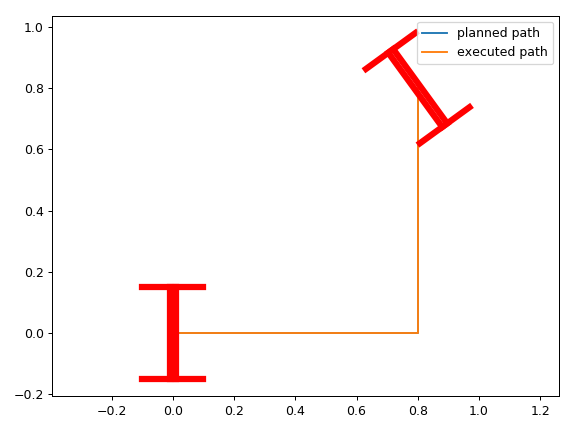

u is  [1.0, 1.0]
u is  [1.0, 1.0]
u is  [-1, 1]
u is  [-1, 1]
u is  [-1, 1]
u is  [-1, 1]
u is  [-1, 1]
u is  [1.0, 1.0]
u is  [1.0, 1.0]
u is  [1, -1]
u is  [1, -1]
u is  [1, -1]


In [7]:
#build the graph
# define nodes and edges
nodes = [] #nodes is a list of tuples, first keep x and y fixed, then move y, finally move x
for i in range(dims[0]): #from 0 to 19
    for j in range(dims[1]):
        for k in range(dims[2]):
            nodes.append((i,j,k))

edges = []
edgeCosts = dict() # in the form {"edge1":cost1, "edge2":cost2...}
edgeControls = dict() # in the form {"edge1":control1, "edge2":control2}
edgeTimes = dict() # in the form {"edge1":time1, "edge2":time2}
for N in nodes:
    #print "N is ", N
    ns,cs,us = neighbors(N)
    for (n,c,u) in zip(ns,cs,us): #zip function returns an iterator of tuples
        #print "zip is ",zip(ns,cs,us)
        #print "n is ", n
        #print "c is ", c
        #print "u is ", u
        e = (N,tuple(n))
        #print "e is ", e 
        edges.append(e)
        #print "edges are ", edges
        edgeCosts[e] = c
        #print "edgeCosts are ",edgeCosts
        edgeControls[e] = u[0]
        #print "edgeControls are ", edgeControls
        edgeTimes[e] = u[1]
        #print "edgeTimes are ", edgeTimes

# build the graph
G = AdjListGraph(nodes,edges)
N0 = state_to_node((0,0,0))
Ngoal = state_to_node((1,1,math.pi/4))
print N0,Ngoal
path = dijkstras(G,N0,Ngoal,cost = lambda v,w:edgeCosts[(v,w)]) #use the defined edge costs here to find a path
print "Path:",path
pathCosts = [edgeCosts[(v,w)] for (v,w) in zip(path[:-1],path[1:])] # compute costs of all two following nodes of the path
pathControls = [edgeControls[(v,w)] for (v,w) in zip(path[:-1],path[1:])] # compute controls of all two following nodes of the path
pathDurations = [edgeTimes[(v,w)] for (v,w) in zip(path[:-1],path[1:])] # compute durations of all two following nodes of the path
pathDurations = [edgeCosts[(v,w)] for (v,w) in zip(path[:-1],path[1:])]
print "Cost:",sum(pathCosts) # compute the sum of all costs to get the path cost
print "Time:",sum(pathDurations) # compute the sum of all durations to get the path durations

#plot the planned and executed paths
#the paths will basically be garbage until you fix this

fig = plt.figure()
ax = plt.subplot(111)
xtraj = np.array([node_to_state(n) for n in path])
ax.plot(xtraj[:,0],xtraj[:,1],label='planned path')
xtraj2 = [node_to_state(path[0])]
for i in range(0,len(path)-1):
    u = pathControls[i]
    print "u is ",u
    dt = pathDurations[i]
    section = dd.integrate(xtraj2[-1],0,u,1e-2,dt)
    #print "section is ", section
    xtraj2 += section[1:]
    #print "xtraj2 is ", xtraj2
xtraj2 = np.array(xtraj2)
ax.plot(xtraj2[:,0],xtraj2[:,1],label='executed path')

dd.plot(xtraj[0,:],ax,color='r')
dd.plot(xtraj[-1,:],ax,color='r')

plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

This looks like rubbish right now, but after you implement a correct search graph, you should be able to achieve reasonable looking paths that respect the dynamic constraints and have close agreement between the planned and executed paths.

In your report, precisely and in technical English language (not code, although pseudocode may be acceptable), describe your strategy for generating nodes, edges, actions, and costs. 


### Enhancing capabilities

Pick at least one of the following options to enhance the capability of your basic algorithm:

1. Correct for the errors introduced by the grid approximation by constructing better open or closed loop policies to steer between grid points more accurately.

2. Write a standalone planner plan(q0,qgoal) that takes an initial configuration q0 and goal configuration qgoal as input, and dynamically determines the domain and resolution for searching.  The grid artifacts should be less apparent, and planning should be faster when q0 and qgoal are close to one another.

3. Modify your basic algorithm to handle obstacles.

4. Use the A\* search algorithm to improve the speed of search.  Devise a heuristic function and argue that it approximates the optimal cost.

Describe your enhancements and results from performance testing in the report.

### Theoretical behavior

1. Describe as precisely as possible all of the inputs and outputs of your planner, so that a user of your planner would be able to confidently interpret how to encode and decode the problem.

2. How does the performance of the planner scale with respect to certain parameters, like the grid size, distance between start and goal, or the choice of actions?

2. Describe the theoretical performance qualities of the planner.  Is it complete?  Optimal?  Probabilistic?

## Unit testing

Perform unit testing of your planner, and describe the performance metrics and test procedure that you are using.  Interpret the observations you have made, including but not limited to:

* Whether performance is sensitive to certain parameters.
* Whether performance limitations or bottlenecks can be identified.
* Whether unit tests agree with theoretical behavior.